# Lab 6 IBM: Jupyter Notebook

In [1]:
!pip install scikit-learn
!pip install --upgrade pixiedust 

Requirement already up-to-date: pixiedust in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.1.18)


In [1]:
import pixiedust
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import arff
import brunel
from watson_machine_learning_client import WatsonMachineLearningAPIClient 

Pixiedust database opened successfully


In [2]:
raw_df=pixiedust.sampleData('https://raw.githubusercontent.com/apischdo/skillsacademy/master/Denormalized%20claims%20data.csv') 

Downloaded 463947 bytes
Creating pandas DataFrame for 'https://raw.githubusercontent.com/apischdo/skillsacademy/master/Denormalized%20claims%20data.csv'. Please wait...
Loading file using 'pandas'
Successfully created pandas DataFrame for 'https://raw.githubusercontent.com/apischdo/skillsacademy/master/Denormalized%20claims%20data.csv'


In [6]:
display(raw_df)

HOUSEHOLD_ID,DRIVER_ID,POLICY_ID,CLAIM_ID,INCIDENT_CAUSE,DESCRIPTION,CLAIM_STATUS,ODOMETER_AT_LOSS,LOSS_EVENT_TIME,CLAIM_INIT_TIME,POLICE_REPORT,CLAIMS_AT_LOSS_DATE,LOSS_LOCATION_LAT,LOSS_LOCATION_LONG,CLAIM_AMOUNT,FLAG_FOR_FRAUD_INV,PRIMARY_DRIVER_ID,START_DATE,EXPIRY_DATE,MODEL_YEAR,MAKE,MODEL,PLATE,COLOR,INITIAL_ODOMETER,LOW_MILEAGE_USE,FIRST_NAME,LAST_NAME,GENDER,BIRTHDATE,SSN,DRIVERS_LICENSE_ID,DRIVERS_LICENSE_EXPIRY,DRIVERS_LICENSE_STATE,DATE_AT_CURRENT_ADDRESS,CONTACT_NUMBER,EMAIL,COMMUTE_DISCOUNT,WORK_ADDR_NUMB,WORK_ADDR_STREET_NAME,WORK_ADDR_UNIT_DESIGNATION,WORK_ADDR_UNIT_NUMBER,WORK_ADDR_CITY,WORK_ADDR_STATE,WORK_ADDR_ZIPCODE,WORK_ADDR_LATITUDE,WORK_ADDR_LONGITUDE,WORK_ADDR_PBKEY,ADDR_STREET_NUMBER,ADDR_STREET_NAME,ADDR_UNIT_DESIGNATION,ADDR_UNIT_NUMBER,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,PBKEY
JE19928,EDY9473,UT2106582,A-2017-FJ800,5,nan,1,215849.8,2017-09-10 00:00:00.0,2017-09-24 00:00:00.0,1,1,41.88994002,-87.62894827,22850.0,1,EDY9473,2016-10-11,2017-10-11,2007,Honda,Accord,DVEB281,Med Red,209208.0,0,Burt,Hinchliffe,M,1970-03-03,724-23-4753,X728-3567-6716,2019-11-20,IL,2001-10-01,745-314-0177,bhinchliffe@husshmail.com,0,5758,N ROCKWELL ST,nan,nan,CHICAGO,IL,60659,41.986652,-87.694763,P00007UUXZLM,2501,S 8TH AVE,nan,nan,NORTH RIVERSIDE,IL,60546,41.844096,-87.840811,-87.840811
BM18312,AFF3821,TQ6819790,A-2018-HF148,1,nan,2,203821.9,2018-12-04 00:00:00.0,2018-12-07 00:00:00.0,1,1,41.90290483,-87.69673176,1970.0,0,IUW9233,2017-05-12,2018-05-12,2009,Toyota,Rav-4,XFKT081,Silver,189768.0,0,Tory,Dinch,M,1936-06-25,766-71-7166,M729-6807-2997,2020-03-03,IL,2000-07-04,245-550-0602,tdinch@freshmaail.com,0,811,MICHIGAN AVE,nan,nan,EVANSTON,IL,60202,42.032542,-87.671971,P00007UWKMGO,538,BLUESTEM LN,nan,nan,GRAYSLAKE,IL,60030,42.33317,-88.00814799999999,-88.00814799999999
BB72793,RYX1074,RW0440982,A-2017-UP277,2,nan,3,45590.9,2017-03-13 00:00:00.0,2017-03-27 00:00:00.0,0,1,41.94296486,-87.68832147,1725.0,0,RYX1074,2016-09-05,2017-09-05,2015,Jeep,Compass,QYUK812,Med. Dark Gray,36072.0,0,Francine,Zaunbrecher,F,2001-03-26,864-18-2502,M169-2916-1811,2020-04-14,IL,2009-04-22,745-365-0368,fzaunbrecher@mooosend.com,0,598,N EAST RIVER RD,nan,nan,DES PLAINES,IL,60016,42.065408000000005,-87.872157,P00007UWIFVG,2252,N SOUTHPORT AVE,nan,nan,CHICAGO,IL,60614,41.923152,-87.663508,-87.663508
HJ36529,ZKI6917,PN5964338,A-2017-II879,3,nan,1,195845.5,2017-09-14 00:00:00.0,2017-09-18 00:00:00.0,1,1,41.73852748,-87.64170134,28760.0,1,ZKI6917,2016-02-07,2017-02-06,2007,Chevrolet,Camaro,ZYYT563,Black,185520.0,0,Neal,Spangler,M,1947-12-21,667-96-9592,X914-4715-2969,2019-04-06,IL,2017-08-17,235-798-0220,nspangler@beemail.com,0,5629,CRESTWOOD RD,nan,nan,MATTESON,IL,60443,41.522545,-87.753062,P00007UTV8FD,4300,189TH ST,nan,nan,COUNTRY CLUB HILLS,IL,60478,41.545664,-87.720754,-87.720754
GB64343,PXE3728,XY6800348,A-2017-CK710,1,nan,3,290975.1,2017-08-12 00:00:00.0,2017-08-25 00:00:00.0,0,1,41.91122338,-87.63865603,2130.0,0,PXE3728,2016-04-14,2017-04-14,2005,Kia,Optima,YSOB682,Med. Dark Gray,280368.0,0,Lea,Vandriessche,F,1984-03-15,597-29-1657,E935-8533-8050,2019-07-02,IL,2017-05-03,751-341-0972,lvandriessche@outloop.com,0,4956,W RACE AVE,nan,nan,CHICAGO,IL,60644,41.8907,-87.750374,P00007UWQWUY,5823,N RAVENSWOOD AVE,APT,114,CHICAGO,IL,60660,41.987778000000006,-87.674221,-87.674221
ED80605,FHM3434,SX6574238,A-2017-SK656,3,nan,3,219581.2,2017-03-17 00:00:00.0,2017-03-18 00:00:00.0,1,1,41.77513858,-87.58475257,2656.5,0,FHM3434,2016-04-14,2017-04-14,2007,Jeep,Grand Cherokee,MACW534,Light Brown,209400.0,0,Gerry,Widmer,M,1947-09-09,366-31-8024,H734-9725-9788,2019-04-25,IL,2011-10-22,338-898-0648,gwidmer@gmxx.com,0,804,W LINCOLN ST,nan,nan,MOUNT PROSPECT,IL,60056,42.059526,-87.94880699999999,P00007UT4E69,665,PASQUINELLI DR,APT,B-105,WESTMONT,IL,60559,41.812834,-87.94977,-87.94977
FF96280,PME9660,YQ4164671,A-2016-EA365,2,nan,3,121593.2,2016-12-04 00:00:00.0,2016-12-17 00:00:00.0,1,2,41.93859158,-87.75656533,2610.0,0,PME9660,2015-11-27,2016-11-26,2011,Subaru,Outb

In [4]:
display(raw_df)


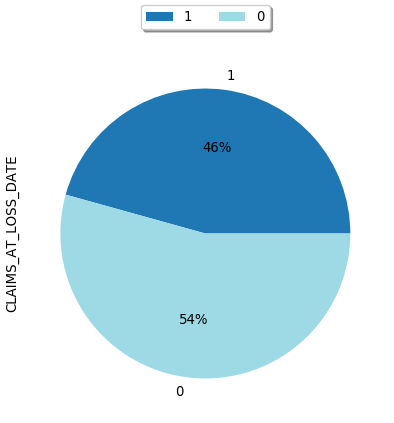

In [5]:
display(raw_df)

In [7]:
display(raw_df)

In [8]:
display(raw_df)

In [9]:
display(raw_df)

In [11]:
# Claim within 15 days of policy expiry (date of loss - insurance_policy.expiry)
raw_df["EXPIRY_DATE"] = pd.to_datetime(raw_df["EXPIRY_DATE"])
raw_df["LOSS_EVENT_TIME"] = pd.to_datetime(raw_df["LOSS_EVENT_TIME"])

raw_df["DAYS_FROM_LOSS"] = raw_df["LOSS_EVENT_TIME"] - raw_df["EXPIRY_DATE"]
raw_df["DAYS_FROM_LOSS"] = abs(raw_df.DAYS_FROM_LOSS.dt.days)

raw_df.loc[raw_df['DAYS_FROM_LOSS'] >= 15, 'SUSPICIOUS_CLAIM_TIME'] = 1
raw_df.loc[raw_df['DAYS_FROM_LOSS'] < 15, 'SUSPICIOUS_CLAIM_TIME'] = 0 

In [12]:
raw_df["SUSPICIOUS_CLAIM_TIME"].value_counts() 

1.0    915
0.0     60
Name: SUSPICIOUS_CLAIM_TIME, dtype: int64

In [13]:
# Expired drivers license (if date of loss > insurance_driver.drivers_license_expiry)
raw_df["DRIVERS_LICENSE_EXPIRY"] = pd.to_datetime(raw_df["DRIVERS_LICENSE_EXPIRY"])

raw_df["DAYS_FROM_L_EXPIRY"] = raw_df["DRIVERS_LICENSE_EXPIRY"] - raw_df["LOSS_EVENT_TIME"]
raw_df["DAYS_FROM_L_EXPIRY"] = raw_df.DAYS_FROM_L_EXPIRY.dt.days

raw_df.loc[raw_df['DAYS_FROM_L_EXPIRY'] >= 0, 'EXPIRED_LICENSE'] = 0
raw_df.loc[raw_df['DAYS_FROM_L_EXPIRY'] < 0, 'EXPIRED_LICENSE'] = 1 

In [14]:
raw_df["EXPIRED_LICENSE"].value_counts() 

0.0    936
1.0     39
Name: EXPIRED_LICENSE, dtype: int64

In [15]:
# Days living at current address (date of loss - insurance_driver.date_at_current_address)

raw_df["DATE_AT_CURRENT_ADDRESS"] = pd.to_datetime(raw_df["DATE_AT_CURRENT_ADDRESS"])
raw_df["DAYS_AT_ADDRESS"] = raw_df["LOSS_EVENT_TIME"] - raw_df["DATE_AT_CURRENT_ADDRESS"]
raw_df["DAYS_AT_ADDRESS"] = abs(raw_df.DAYS_AT_ADDRESS.dt.days)

raw_df.loc[raw_df['DAYS_AT_ADDRESS'] >= 15, 'SUSPICIOUS_LIVING'] = 1
raw_df.loc[raw_df['DAYS_AT_ADDRESS'] < 15, 'SUSPICIOUS_LIVING'] = 0

In [16]:
raw_df["SUSPICIOUS_LIVING"].value_counts() 

1.0    973
0.0      2
Name: SUSPICIOUS_LIVING, dtype: int64

In [17]:
#7500/year
raw_df["START_DATE"] = pd.to_datetime(raw_df["START_DATE"])
#find number of days between policy creation and accident
raw_df["LENGTH_OF_POLICY"]=(raw_df["LOSS_EVENT_TIME"] - raw_df["START_DATE"]).dt.days

#convert to years
raw_df["LENGTH_OF_POLICY"]=raw_df["LENGTH_OF_POLICY"]/365

#divide Odometer at loss by years
raw_df["MILES/YEAR"] = raw_df["ODOMETER_AT_LOSS"]/raw_df["LENGTH_OF_POLICY"]
raw_df["MILES/YEAR"].value_counts() 

145432.118234    1
234953.253233    1
55515.574648     1
123525.401515    1
198472.566993    1
41161.635017     1
316044.542945    1
343652.573991    1
357034.135714    1
444934.671171    1
47761.055147     1
106608.700207    1
280168.774737    1
97407.709325     1
83715.343421     1
836054.660714    1
225418.465704    1
119793.802198    1
49174.210227     1
154269.516340    1
87012.862810     1
55960.766821     1
340284.423841    1
55199.213855     1
158134.051821    1
148190.243875    1
128341.984375    1
388218.025735    1
38327.581707     1
311332.643229    1
                ..
138485.866667    1
355749.475610    1
206160.525547    1
172133.553061    1
39974.457997     1
129429.385563    1
227492.647193    1
581033.280000    1
213403.812808    1
129338.850177    1
433650.444700    1
428016.279255    1
102579.963602    1
924887.694444    1
258935.458015    1
219977.172330    1
167467.854637    1
110428.874687    1
140508.777778    1
189399.690217    1
54898.636569     1
42573.963602

In [19]:
# Conflict on whether a policyholder with a low mileage discount experienced a loss with high mileage at the point of loss 
raw_df.loc[raw_df["MILES/YEAR"] <7500, 'LOW_MILEAGE_AT_LOSS'] = 1
raw_df.loc[raw_df["MILES/YEAR"] >=7500, 'LOW_MILEAGE_AT_LOSS'] = 0 

In [20]:
raw_df.loc[raw_df["LOW_MILEAGE_USE"]==raw_df["LOW_MILEAGE_AT_LOSS"], 'SUSPICIOUS_MILEAGE'] = 0
raw_df.loc[raw_df["LOW_MILEAGE_USE"]!=raw_df["LOW_MILEAGE_AT_LOSS"], 'SUSPICIOUS_MILEAGE'] = 1

In [21]:
raw_df.loc[raw_df["CLAIM_AMOUNT"] <3000, 'EXCESSIVE_CLAIM_AMOUNT'] = 0
raw_df.loc[raw_df["CLAIM_AMOUNT"] >=3000, 'EXCESSIVE_CLAIM_AMOUNT'] = 1 

In [22]:
# dataframes for certain features
features = ['FLAG_FOR_FRAUD_INV', 
 'SUSPICIOUS_MILEAGE',
 'EXPIRED_LICENSE',
 'SUSPICIOUS_CLAIM_TIME',
 'SUSPICIOUS_LIVING',
 'EXCESSIVE_CLAIM_AMOUNT'] 

In [23]:
df_model = raw_df[features] 

In [24]:
df_model.head()

,FLAG_FOR_FRAUD_INV,SUSPICIOUS_MILEAGE,EXPIRED_LICENSE,SUSPICIOUS_CLAIM_TIME,SUSPICIOUS_LIVING,EXCESSIVE_CLAIM_AMOUNT
0,1,0.0,0.0,1.0,1.0,1.0
1,0,0.0,1.0,1.0,1.0,0.0
2,1,1.0,0.0,1.0,1.0,1.0
3,1,0.0,0.0,1.0,1.0,1.0
4,0,0.0,0.0,1.0,1.0,0.0


In [25]:
#ensure all relevant features are integers
df_model["SUSPICIOUS_LIVING"] = df_model["SUSPICIOUS_LIVING"].astype(int)
df_model["EXPIRED_LICENSE"] = df_model["EXPIRED_LICENSE"].astype(int)
df_model["SUSPICIOUS_CLAIM_TIME"] = df_model["SUSPICIOUS_CLAIM_TIME"].astype(int)
df_model["SUSPICIOUS_MILEAGE"] = df_model["SUSPICIOUS_MILEAGE"].astype(int)
df_model["EXCESSIVE_CLAIM_AMOUNT"] = df_model["EXCESSIVE_CLAIM_AMOUNT"].astype(int) 

In [26]:
raw_df.groupby("FLAG_FOR_FRAUD_INV", as_index=False).mean() 

,FLAG_FOR_FRAUD_INV,INCIDENT_CAUSE,DESCRIPTION,CLAIM_STATUS,ODOMETER_AT_LOSS,POLICE_REPORT,CLAIMS_AT_LOSS_DATE,LOSS_LOCATION_LAT,LOSS_LOCATION_LONG,CLAIM_AMOUNT,...,SUSPICIOUS_CLAIM_TIME,DAYS_FROM_L_EXPIRY,EXPIRED_LICENSE,DAYS_AT_ADDRESS,SUSPICIOUS_LIVING,LENGTH_OF_POLICY,MILES/YEAR,LOW_MILEAGE_AT_LOSS,SUSPICIOUS_MILEAGE,EXCESSIVE_CLAIM_AMOUNT
0,0,2.926186,NaN,2.977153,180783.846046,0.281195,1.492091,41.857895,-87.675014,2521.147627,...,0.933216,894.546573,0.042179,3487.956063,0.996485,1.070159,205170.356701,0.0,0.094903,0.086116
1,1,3.041872,NaN,1.103448,175504.046305,0.637931,1.758621,41.860133,-87.679617,26429.480296,...,0.945813,917.960591,0.036946,3252.413793,1.000000,0.960490,230687.578997,0.0,0.088670,0.933498


In [28]:
#split data into x and y variables
xVar =df_model[["EXPIRED_LICENSE","SUSPICIOUS_CLAIM_TIME","SUSPICIOUS_LIVING","SUSPICIOUS_MILEAGE","EXCESSIVE_CLAIM_AMOUNT"]]
yVar = df_model["FLAG_FOR_FRAUD_INV"] 

In [29]:
xVar.head() 

,EXPIRED_LICENSE,SUSPICIOUS_CLAIM_TIME,SUSPICIOUS_LIVING,SUSPICIOUS_MILEAGE,EXCESSIVE_CLAIM_AMOUNT
0,0,1,1,0,1
1,1,1,1,0,0
2,0,1,1,1,1
3,0,1,1,0,1
4,0,1,1,0,0


In [30]:
#split into a test/train set
X_train, X_test, y_train, y_test = train_test_split(xVar, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape) 

(780, 5) (780,)
(195, 5) (195,)


In [31]:
#train model
clf = RandomForestClassifier(n_jobs=2, random_state=0)

clf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
#create confusion matrix to gut check model
preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,102,9
1,7,77
